In [1]:
%matplotlib inline
import math
from itertools import count, product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier, NeuralNet
from torch import nn, optim
from torch.distributions import Bernoulli, Normal
from torch.nn import functional as F
from torch.utils.data import DataLoader

from cml_data_tools.vae import BetaTCVAE, BetaTCVAELoss

/Users/stilljm/opt/miniconda3/envs/vae_experiments/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
mnist = fetch_openml('mnist_784')

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X.min(), X.max(), X_train.shape, y_train.shape

(0.0, 1.0, (52500, 784), (52500,))

In [3]:
class MnistVAE(BetaTCVAE):
    def __init__(self, beta=1, lamb=0):
        encoder = nn.Sequential(nn.Linear(784, 400),
                                nn.ReLU(),
                                nn.Linear(400, 200),
                                nn.ReLU(),
                                nn.Linear(200, 100),
                                nn.ReLU())
        decoder = nn.Sequential(nn.Linear(20, 100),
                                nn.ReLU(),
                                nn.Linear(100, 200),
                                nn.ReLU(),
                                nn.Linear(200, 400),
                                nn.ReLU(),
                                nn.Linear(400, 784))
        super().__init__(encoder, decoder, e=100, z=20, beta=beta)
        self.ds_len = len(X_train)
        
# Gets nothing but NaN from the loss... why?        
#     def encode(self, x):
#         z, mu, std = super().encode(x)
#         return torch.exp(z), mu, std
        
    def forward(self, x):
        return super().forward(x, self.ds_len)

In [4]:
net = NeuralNet(module=MnistVAE,
                module__beta=6,
                criterion=BetaTCVAELoss,
                optimizer=optim.Adam,
                lr=1e-3,
                max_epochs=10)

In [5]:
torch.manual_seed(120)

In [6]:
%time net.fit(X_train, y=X_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1242.4695     1221.8092  7.3867
      2     1214.8292     1205.6694  7.7226
      3     1198.0997     1192.6399  9.5271
      4     1188.6949     1186.5627  10.1092
      5     1184.7668     1184.1732  10.2739
      6     1182.6590     1182.3427  10.1415
      7     1181.2030     1180.9825  10.5409
      8     1180.0705     1180.4885  10.3681
      9     1179.2122     1179.5836  10.1311
     10     1178.5074     1178.9191  10.1612
CPU times: user 16min 45s, sys: 15.7 s, total: 17min 1s
Wall time: 1min 36s


<class 'skorch.net.NeuralNet'>[initialized](
  module_=MnistVAE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=200, bias=True)
      (3): ReLU()
      (4): Linear(in_features=200, out_features=100, bias=True)
      (5): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=200, bias=True)
      (3): ReLU()
      (4): Linear(in_features=200, out_features=400, bias=True)
      (5): ReLU()
      (6): Linear(in_features=400, out_features=784, bias=True)
    )
    (mu): Linear(in_features=100, out_features=20, bias=True)
    (logvar): Linear(in_features=100, out_features=20, bias=True)
  ),
)

In [7]:
@torch.no_grad()
def sweep_variable_across_samples(vae, samples, i, sweep):
    """Sweeps a single latent variable
    
    Arguments
    ---------
    vae : torch.Module
        A VAE module; must have a decode method
    samples : n-by-z array-like
        Contains n samples of z latent variables
    i : int < z
        The latent variable to sweep
    sweep : array
        The values to use in sweeping z
    """
    # XXX dumb, unvectorized version
    recons = []
    for sample in samples:
        recons.append([])
        for val in sweep:
            sample[i] = val
            img = torch.sigmoid(vae.decoder(sample))
#             xdist = Bernoulli(logits=img)
#             probs = xdist.log_prob(img).detach().numpy()
            recons[-1].append(img.detach().numpy())
    return np.array(recons)

In [8]:
def plot_sweep_grid(origs, recons, sweepvals):
    # n = number samples, m = number variables
    idx = count(1)
    fig = plt.figure(figsize=(15, 13))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i in range(10):
        plt.subplot(10, 11, next(idx))
        plt.imshow(origs[i].reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Orig')
        for j in range(10):
            plt.subplot(10, 11, next(idx))
            plt.imshow(recons[i][j].reshape(28, 28))
            plt.xticks([])
            plt.yticks([])
            if i == 0:
                plt.title(f'{sweepvals[j]:.2f}')
    plt.show()

In [9]:
# Find a set with one from each digit
# 0 = 1
# 1 = 3
# 2 = 5
# 3 = 7
# 4 = 2
# 5 = 0
# 6 = 13
# 7 = 15
# 8 = 17
# 9 = 4
digits = X[[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]]
digits.shape

(10, 784)

In [10]:
with torch.no_grad():
    m = net.module_
    h = m.encoder(torch.tensor(digits))
    mu, logvar = m.mu(h), m.logvar(h)
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    digit_encodings = mu + std*eps
    sweep_range = torch.linspace(-4, 4, steps=10)

Sweeping reconstructions over latent variable no. 0


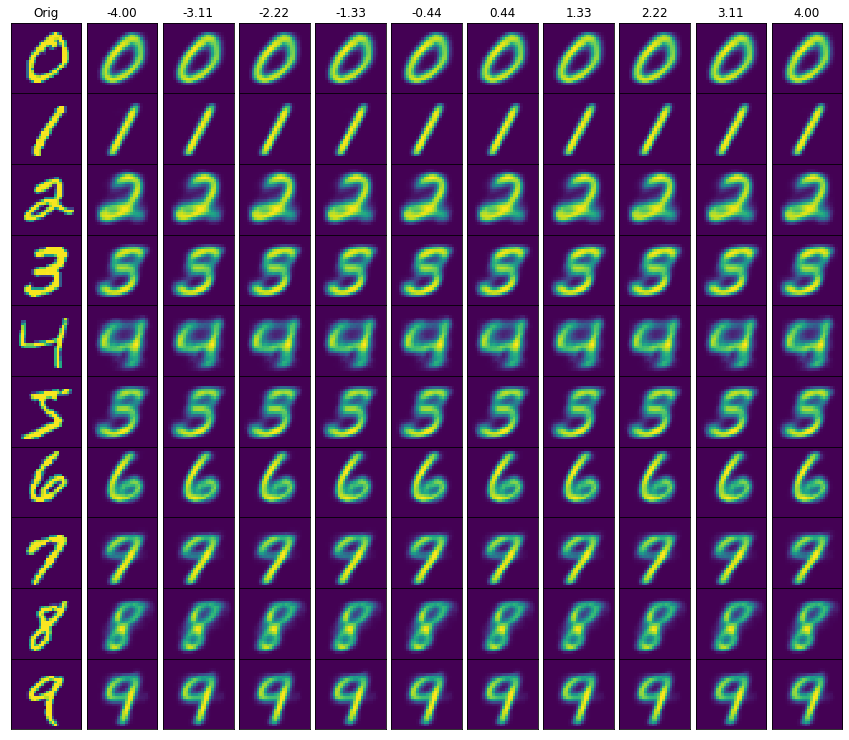

Sweeping reconstructions over latent variable no. 1


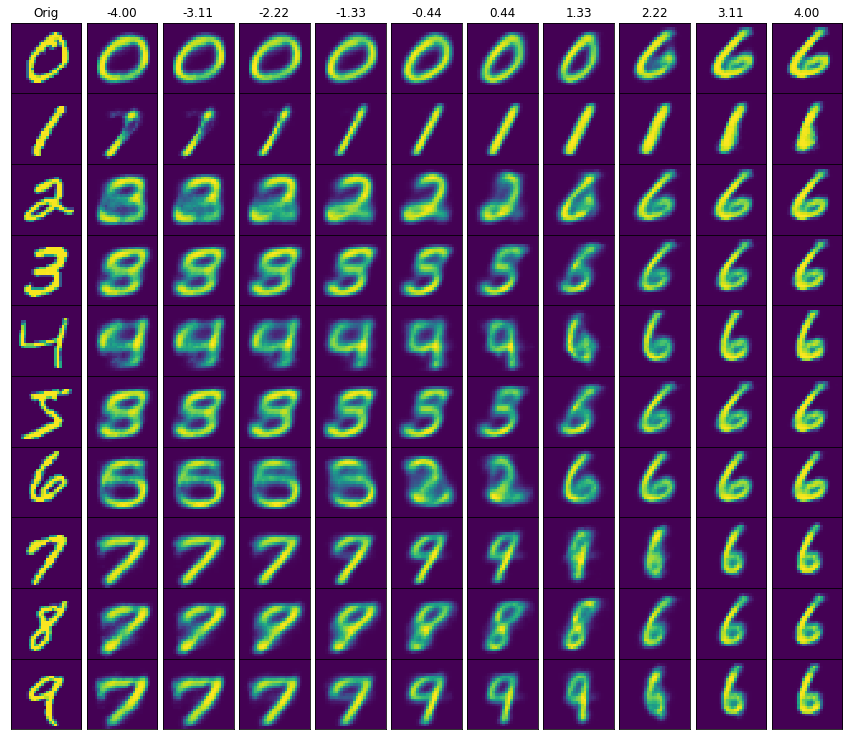

Sweeping reconstructions over latent variable no. 2


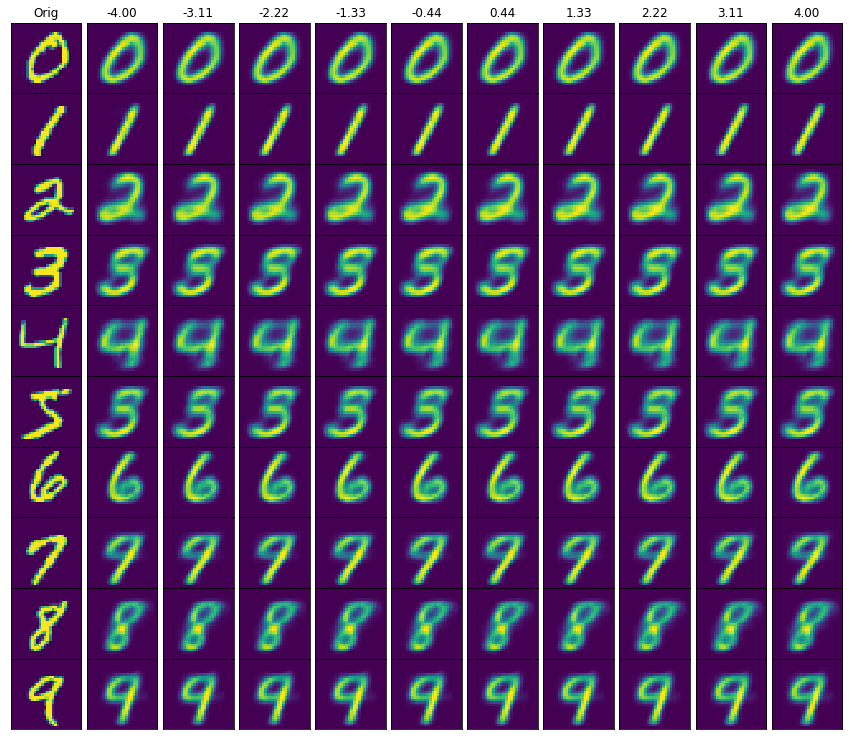

Sweeping reconstructions over latent variable no. 3


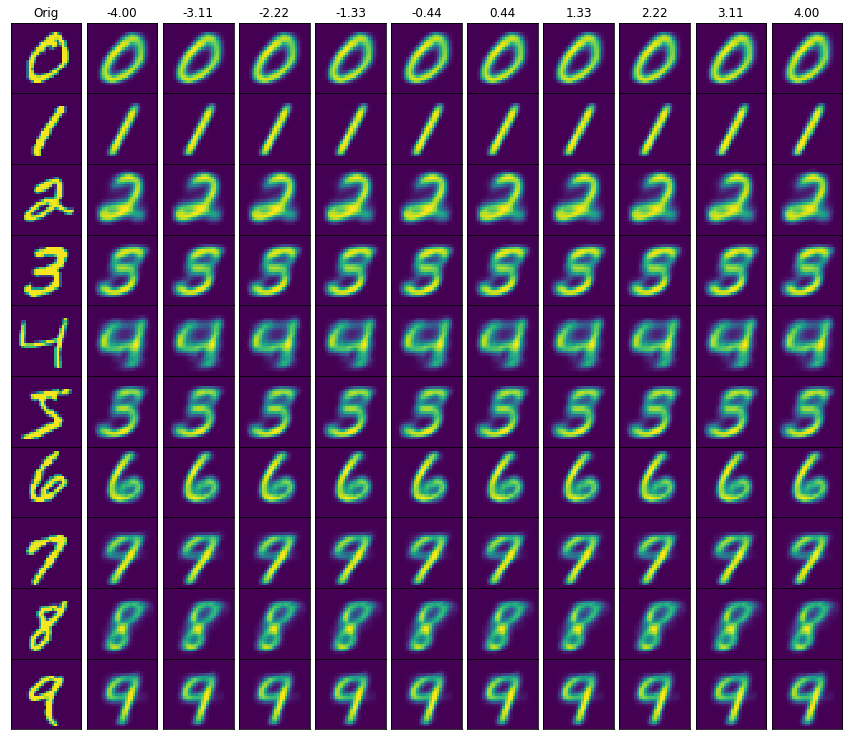

Sweeping reconstructions over latent variable no. 4


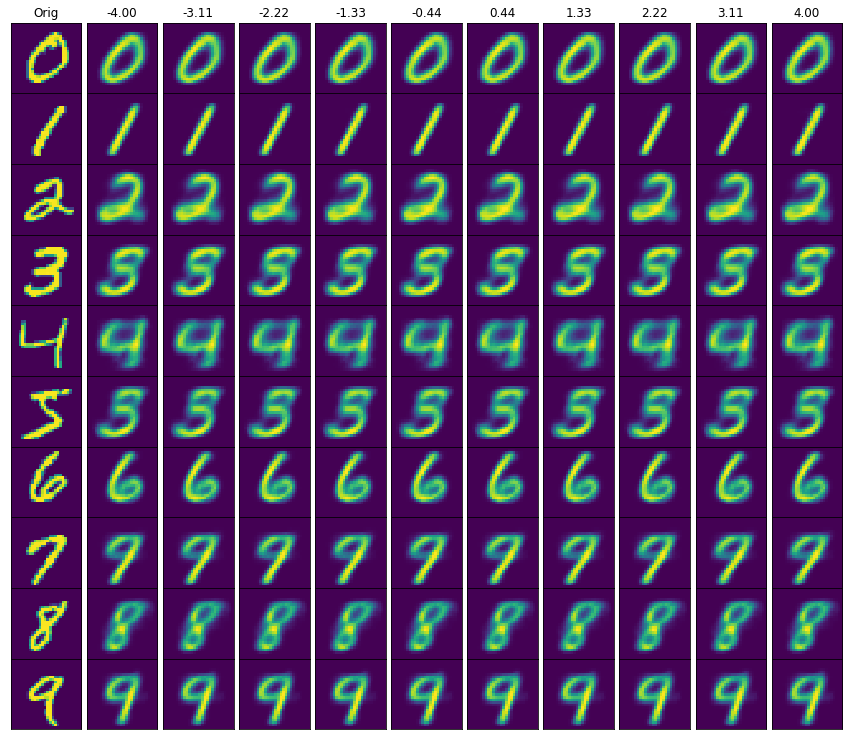

Sweeping reconstructions over latent variable no. 5


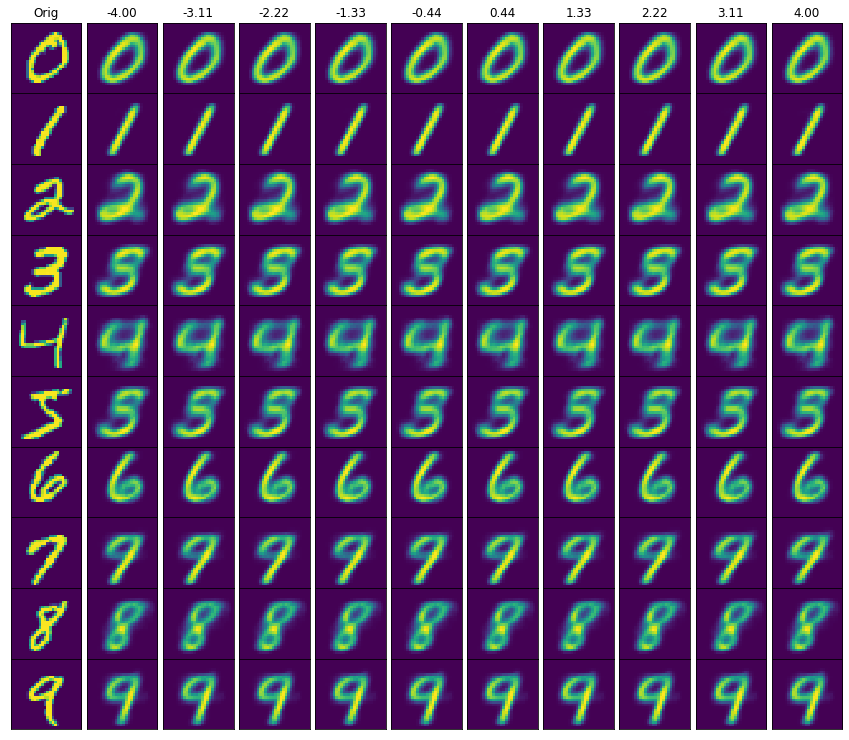

Sweeping reconstructions over latent variable no. 6


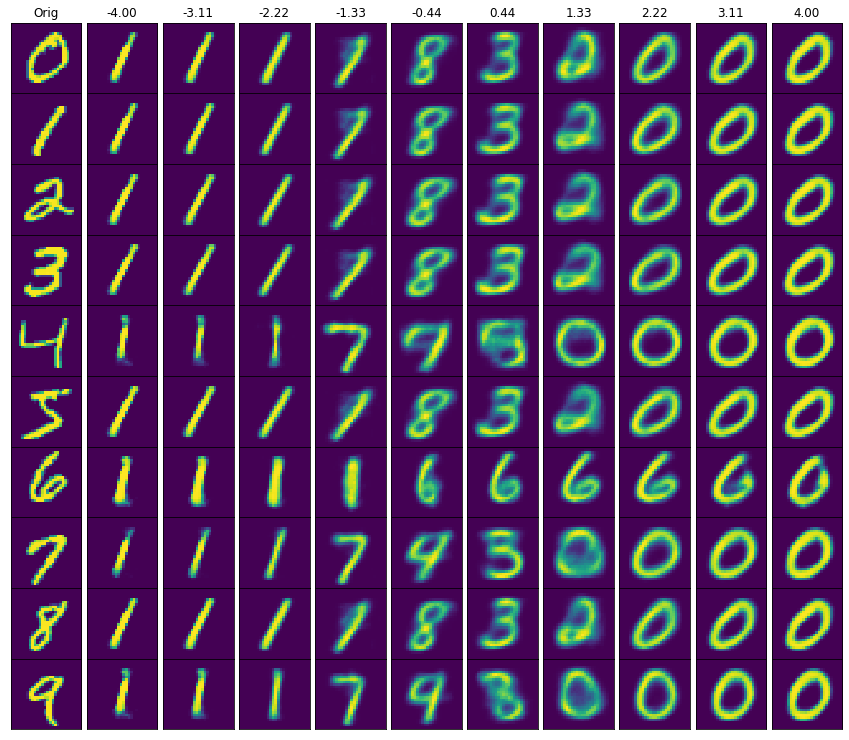

Sweeping reconstructions over latent variable no. 7


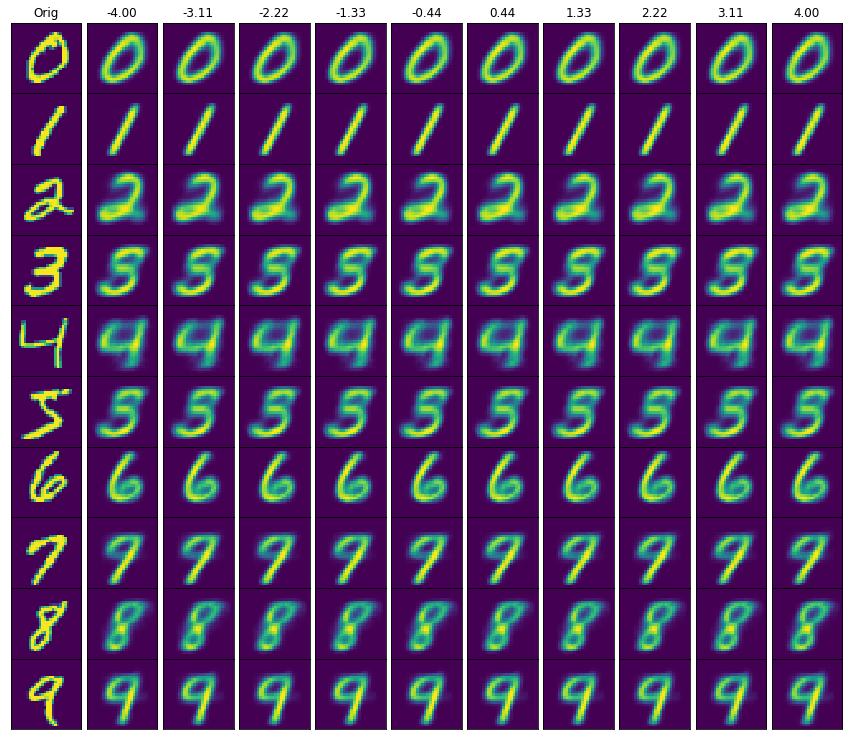

Sweeping reconstructions over latent variable no. 8


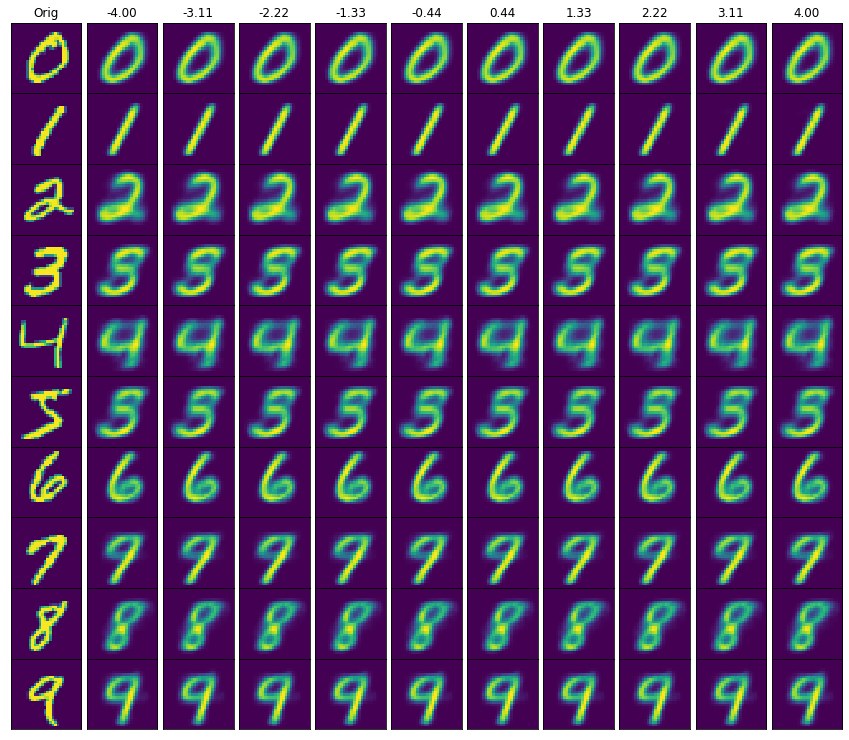

Sweeping reconstructions over latent variable no. 9


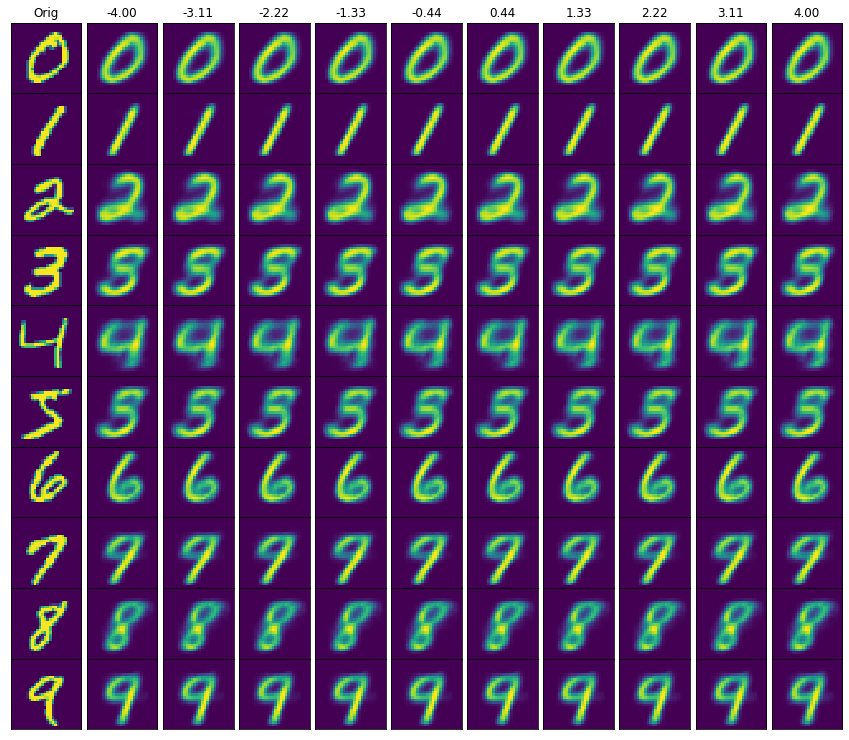

Sweeping reconstructions over latent variable no. 10


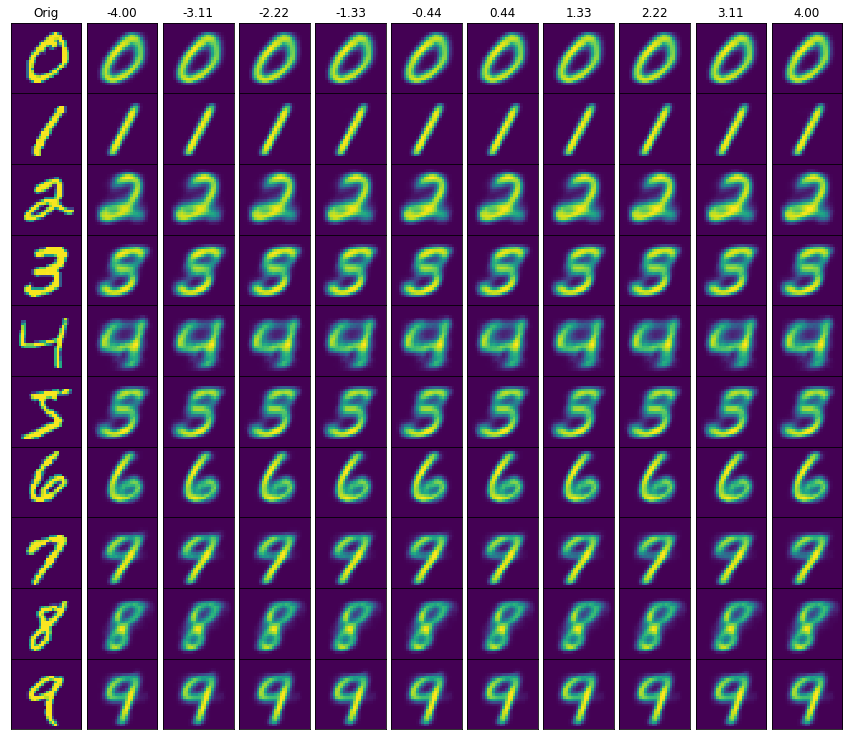

Sweeping reconstructions over latent variable no. 11


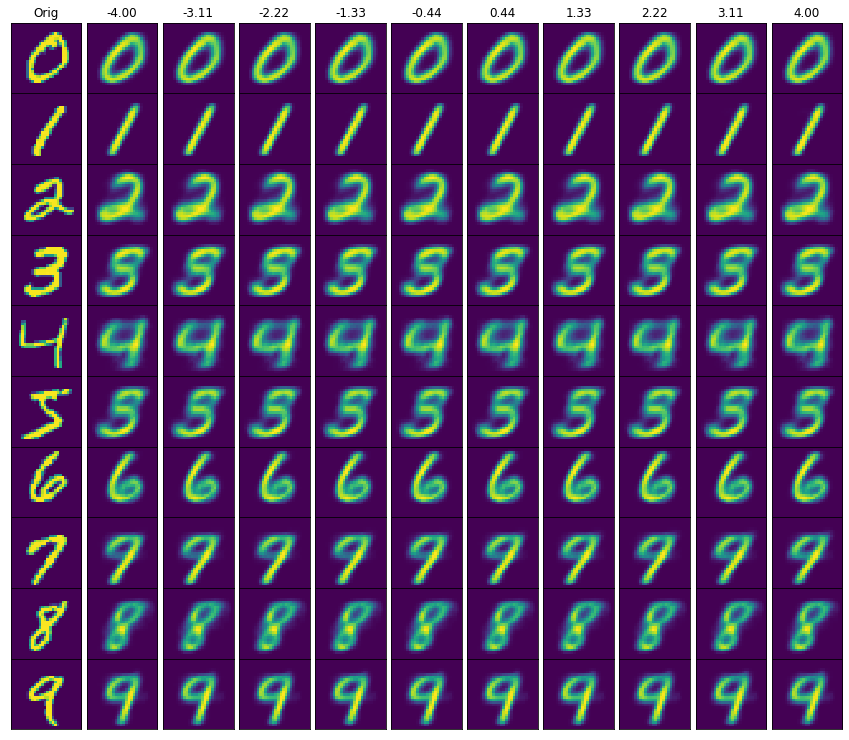

Sweeping reconstructions over latent variable no. 12


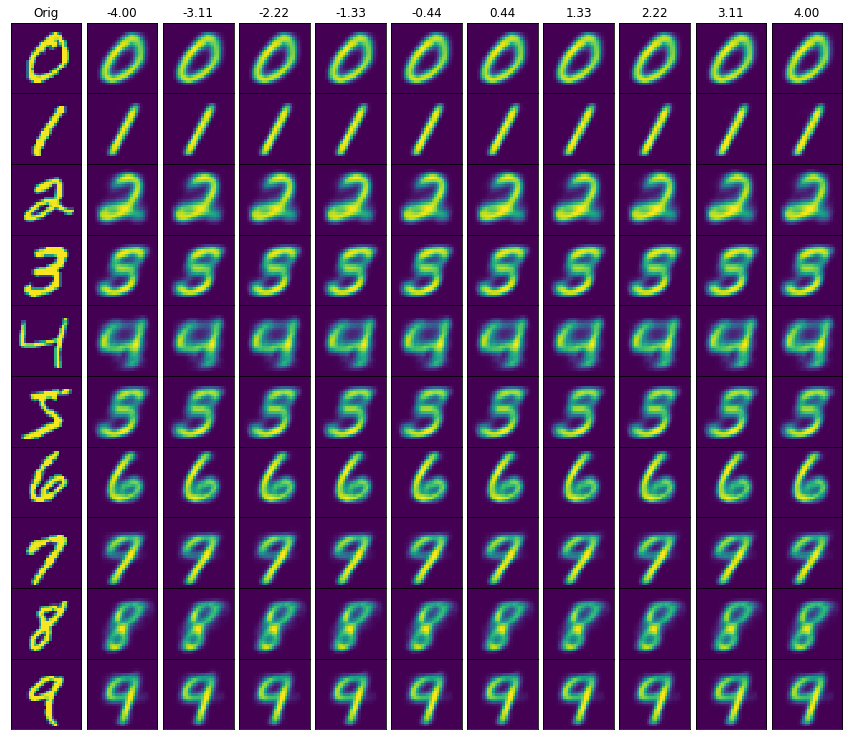

Sweeping reconstructions over latent variable no. 13


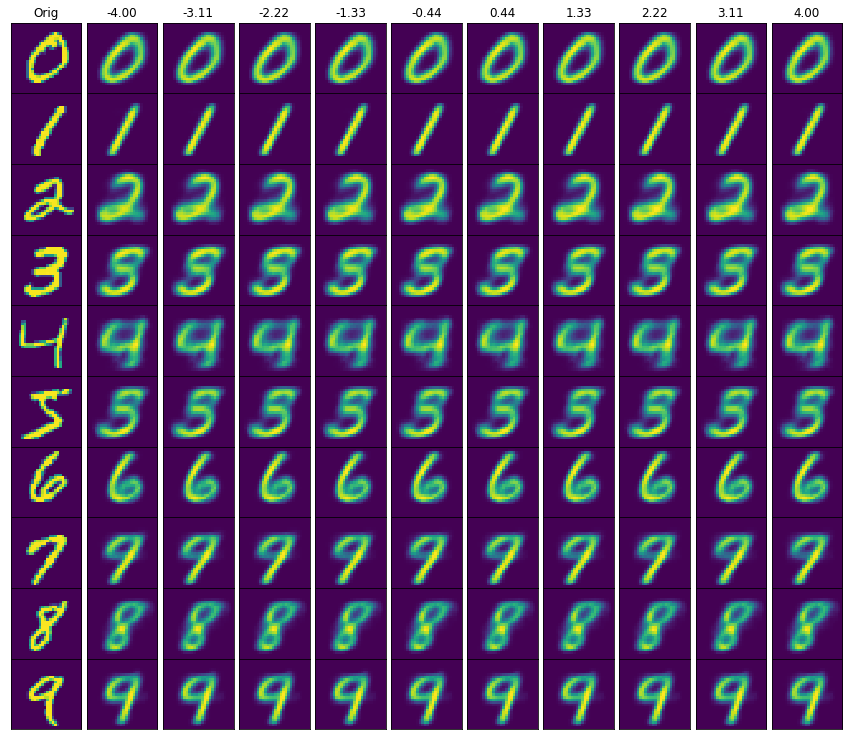

Sweeping reconstructions over latent variable no. 14


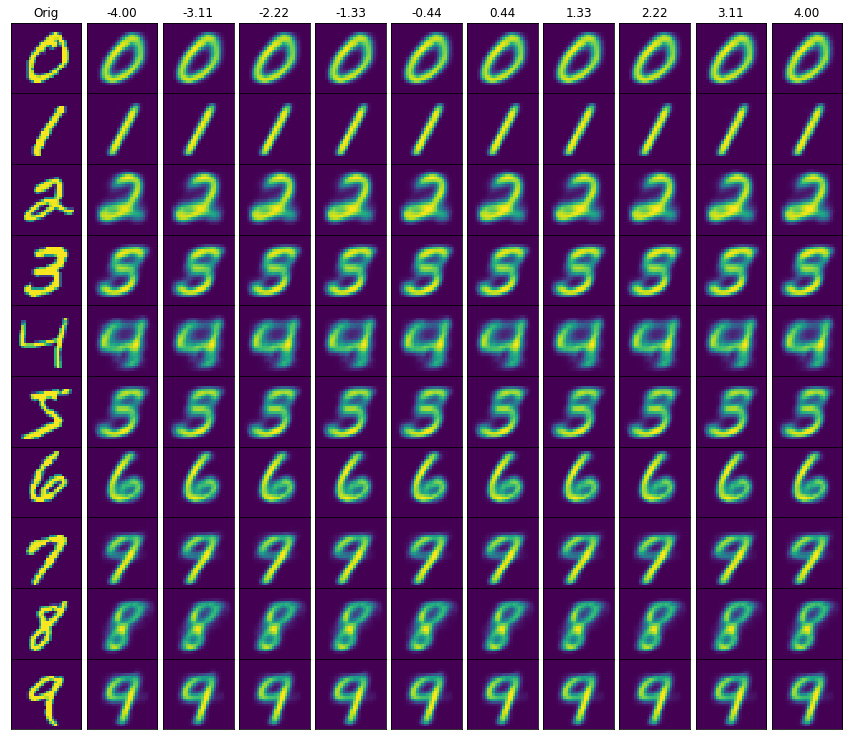

Sweeping reconstructions over latent variable no. 15


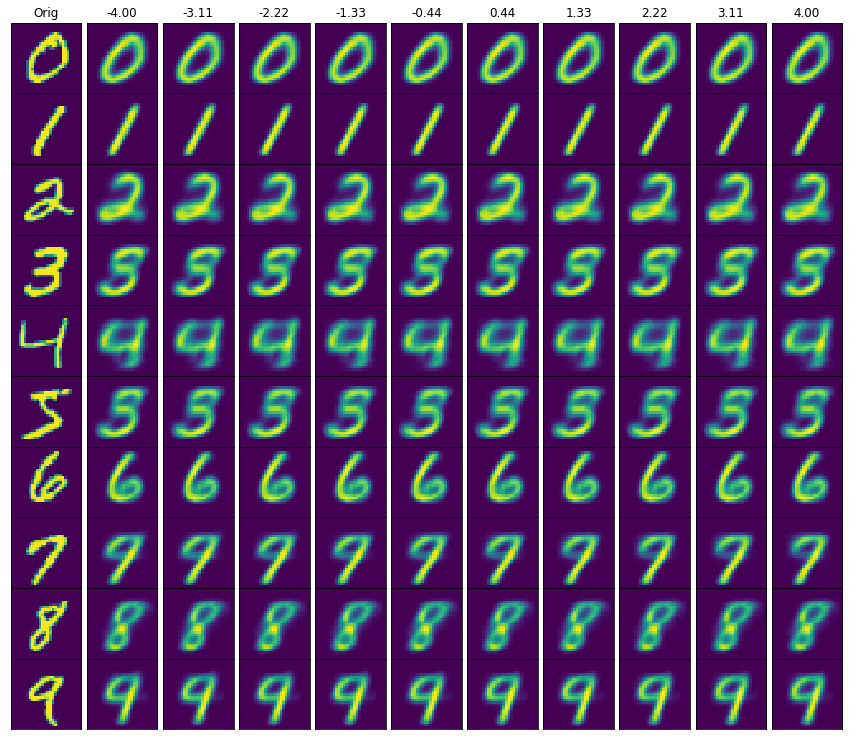

Sweeping reconstructions over latent variable no. 16


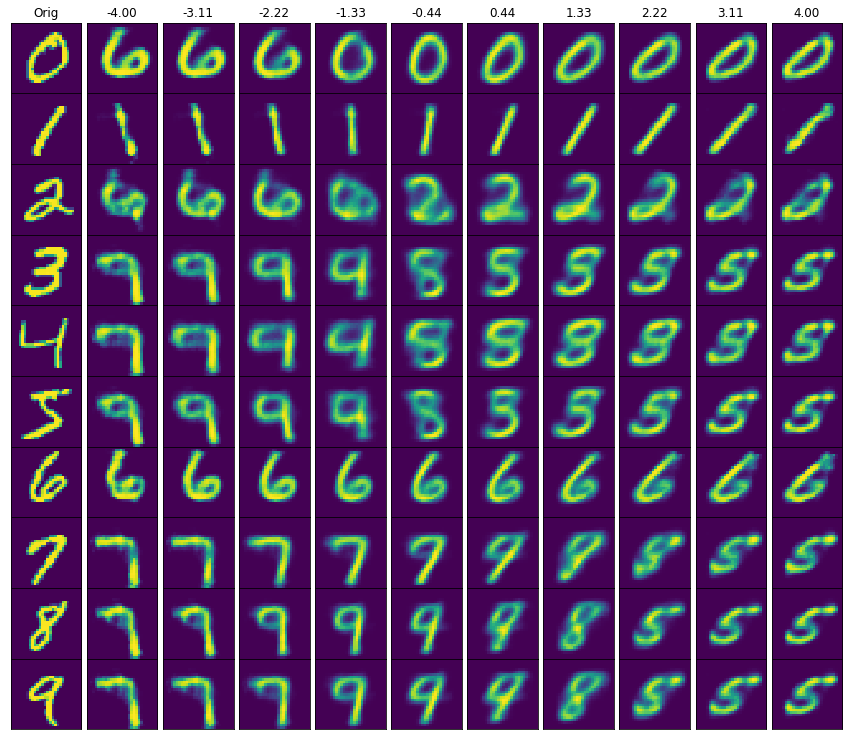

Sweeping reconstructions over latent variable no. 17


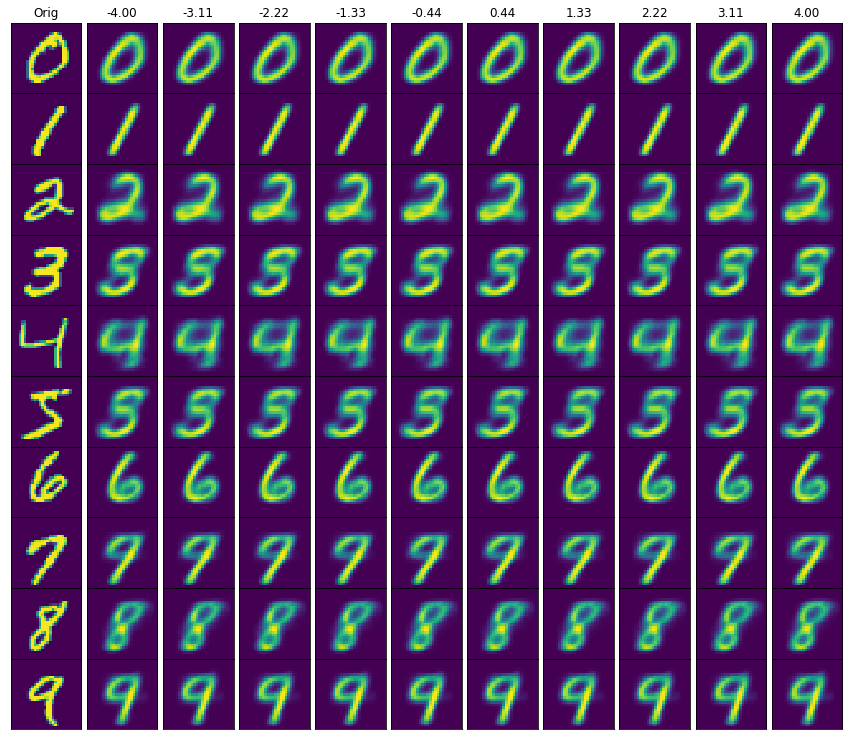

Sweeping reconstructions over latent variable no. 18


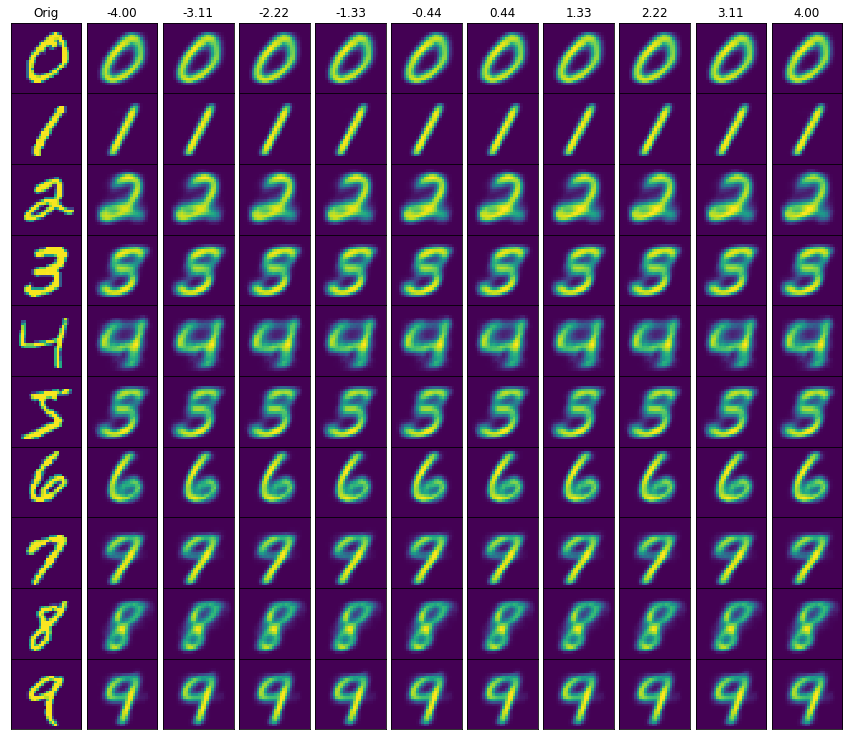

Sweeping reconstructions over latent variable no. 19


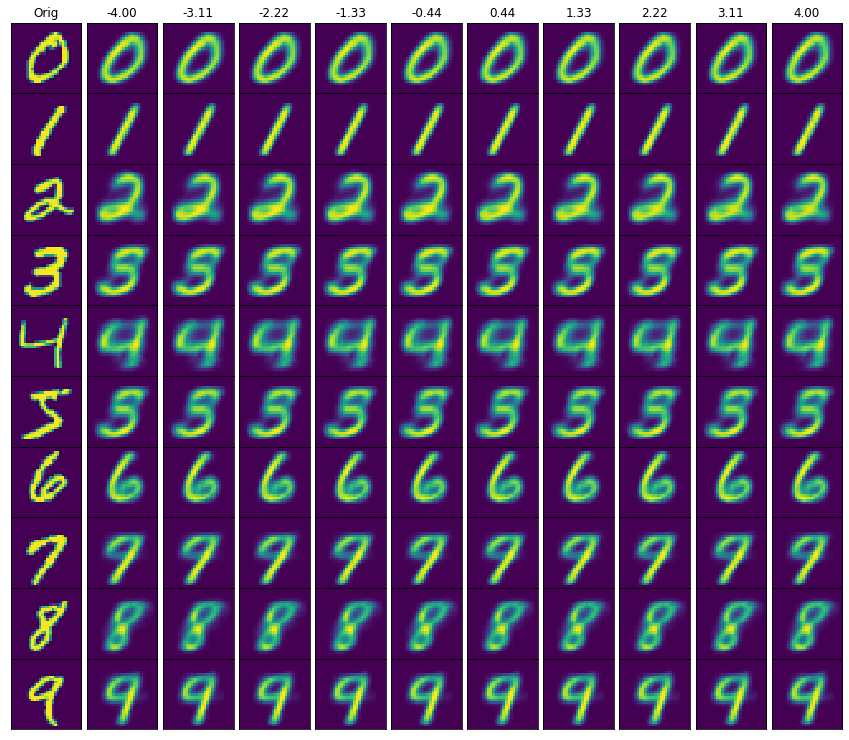

In [11]:
for i in range(20):
    print(f'Sweeping reconstructions over latent variable no. {i}')
    enc = digit_encodings.clone()
    recons_by_var = sweep_variable_across_samples(net.module_, enc, i, sweep_range)
    plot_sweep_grid(digits, recons_by_var, sweep_range)

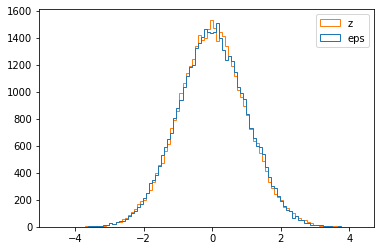

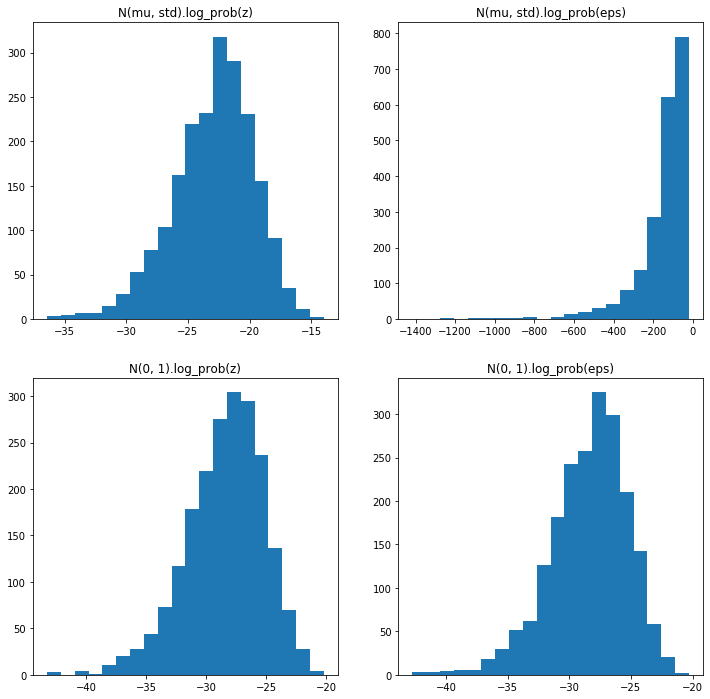

In [12]:
size = 2048

with torch.no_grad():
#     torch.manual_seed(120)
    ds = torch.tensor(X_train[:size])

    h = m.encoder(ds)
    mu, logvar = m.mu(h), m.logvar(h)
    std = torch.exp(0.5*logvar)
    
    standard = Normal(torch.zeros(size, 20), torch.ones(size, 20))
    qdist = Normal(mu, std)
    
#     eps = torch.randn_like(std)
    eps = standard.sample()
#     z = mu + std*eps
    z = Normal(mu, std).sample()
    
    s = [torch.flatten(eps).detach().numpy(), torch.flatten(z).detach().numpy()]
    plt.hist(s, bins=100, histtype='step', fill=False, label=['eps', 'z'])
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.hist(qdist.log_prob(z).view(size, -1).sum(1), bins=20)
    plt.title('N(mu, std).log_prob(z)')
    
    plt.subplot(222)
    plt.hist(qdist.log_prob(eps).view(size, -1).sum(1), bins=20)
    plt.title('N(mu, std).log_prob(eps)')
    
    plt.subplot(223)
    plt.hist(standard.log_prob(z).view(size, -1).sum(1), bins=20)
    plt.title('N(0, 1).log_prob(z)')
    
    plt.subplot(224)
    plt.hist(standard.log_prob(eps).view(size, -1).sum(1), bins=20)
    plt.title('N(0, 1).log_prob(eps)')
        
    plt.show()